In [1]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import torch
import scipy
import pickle
from numpy import dot
from tqdm.notebook import tqdm
from numpy.linalg import norm
from scipy.stats import pearsonr
from operator import itemgetter
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

### Child vocabulary

In [2]:
# create dataframe for aoa dataset --> (word, age_avg)
aoa = pd.read_excel('../data/AoA_ratings.xlsx')
aoa.drop(aoa.columns[[1, 2, 3, 5, 6]], axis = 1, inplace = True) # we are only interested in the mean column
aoa.dropna(inplace=True)
# convert aoa from years+months to just months
aoa['Rating.Mean'] = aoa['Rating.Mean'].apply(lambda x: int(str(x).split('.')[0]) * 12 + x%1.0)
aoa_vocab = list(aoa.Word)
aoa

,Word,Rating.Mean
0,a,24.893384
1,aardvark,108.890000
2,abacus,96.690000
3,abalone,144.230000
4,abandon,96.320000
...,...,...
31119,zoom,96.570000
31120,zoon,144.430000
31121,zucchini,72.790000
31122,zwieback,192.100000


In [3]:
vocab = [line.strip() for line in open('../data/vertomul.txt')]
vocab = [x for x in vocab if x in aoa_vocab]

len(vocab)

511

### Unpack Layers

In [24]:
free_assoc = pickle.load( open( "free_assoc.pickle", "rb" ))
co_oc = pickle.load( open( "co_oc.pickle", "rb" ))
phon_conn = pickle.load( open( "phon_conn.pickle", "rb" ))
feat_norms = pickle.load( open( "feat_norms.pickle", "rb" ))
word_emb_layer = pickle.load( open( "word_emb_layer.pickle", "rb" ))
visual_layer = pickle.load( open( "visual_graph.pickle", "rb" ))
lancaster_layer = pickle.load( open( "lancaster.pickle", "rb" ))

In [181]:
lancaster_layer

[('above', 'around'),
 ('above', 'crib'),
 ('above', 'inside'),
 ('above', 'stay'),
 ('above', 'there'),
 ('above', 'up'),
 ('above', 'wait'),
 ('after', 'before'),
 ('after', 'finish'),
 ('after', 'for'),
 ('after', 'mad'),
 ('after', 'there'),
 ('after', 'time'),
 ('after', 'tomorrow'),
 ('after', 'wait'),
 ('after', 'when'),
 ('after', 'yesterday'),
 ('airplane', 'all'),
 ('airplane', 'around'),
 ('airplane', 'aunt'),
 ('airplane', 'away'),
 ('airplane', 'bathtub'),
 ('airplane', 'bear'),
 ('airplane', 'bedroom'),
 ('airplane', 'bee'),
 ('airplane', 'behind'),
 ('airplane', 'big'),
 ('airplane', 'block'),
 ('airplane', 'boat'),
 ('airplane', 'boy'),
 ('airplane', 'break'),
 ('airplane', 'bring'),
 ('airplane', 'bug'),
 ('airplane', 'build'),
 ('airplane', 'bus'),
 ('airplane', 'buy'),
 ('airplane', 'careful'),
 ('airplane', 'child'),
 ('airplane', 'church'),
 ('airplane', 'close'),
 ('airplane', 'clown'),
 ('airplane', 'country'),
 ('airplane', 'cover'),
 ('airplane', 'cowboy'),
 ('

In [25]:
lists = [ co_oc, phon_conn, free_assoc, feat_norms, word_emb_layer, visual_layer, lancaster_layer]

### Construct weighted graph

In [26]:
# setting the weights. If the connection between two nodes is established across multiple layers, we up its weight
def construct_graph_from_vocab(start_vocab, lists):
    aggregate = nx.Graph()
    aggregate.add_nodes_from(start_vocab)
    aggregate.number_of_nodes()
    for a_list in lists:
        for pair in a_list:
            if pair[0] not in start_vocab: continue
            if pair[1] not in start_vocab: continue
            if aggregate.has_edge(pair[0], pair[1]):
                aggregate[pair[0]][pair[1]]['weight'] += 1
            else:
                aggregate.add_edge(pair[0], pair[1], weight=1)
    return aggregate
    

In [27]:
start_vocab = random.sample(vocab, 29)
left_vocab = list(vocab)
for v in start_vocab: left_vocab.remove(v)
    
len(start_vocab), len(left_vocab), len(vocab)

(29, 482, 511)

In [28]:
agg = construct_graph_from_vocab(start_vocab, lists)
agg.number_of_nodes()

29

In [29]:
def normalize_weights(G):
    '''
     This function creates a list of
     normalized weights for each node 
     in the G graph. The sum of the 
     weights sum to 1.
    '''
    normalized_weights = {}
    weights = list(G.degree(weight='weight')) # strength of each node
    overall = sum(node[1] for node in weights) # sum of all weights in graph 
    
    for node, weight in weights:
        perc = weight/overall
        normalized_weights[node]=(weight, perc)
    
    return normalized_weights

In [30]:
def get_node_connections(G, batch):
    '''
     This function returns a list of
     tuples with (node, edge) pairings
     for each connection a node has. 
    '''
    list_conns = []
    for node in batch:
        list_conns.append(G.edges(node))
    return list_conns

In [186]:
def preferential_attachment(G, newly_added):
    '''
     preferential attachment function call takes in a graph 
     and a list of tuples --> for each node in the batch list,
     get all of its edges and create a list of tuples.
    '''
    
    # create a list of tuples (node, edge) for each edge a node has
    list_conns = get_node_connections(G, newly_added)
    
    node_avgs_list = []
    for arr in list_conns:
        # compute preferential attachment on batch nodes
       
        preds = nx.preferential_attachment(G, arr)
        
        # get the average of all the attachments for each node
        node_avgs = np.mean([p for u,v,p in preds])
        if math.isnan(node_avgs): node_avgs = 0
        node_avgs_list.append(node_avgs)
        
    # list with averages preferential attachment scorer for each node in batch
    zip_lists = list(zip(newly_added, node_avgs_list))

    return zip_lists

In [32]:
def get_aoa_means_for_vocab(aoa, vocab):
    sub = aoa[aoa.Word.isin(vocab)]

    return sub

def get_aoa_rank_for_vocab(aoa, vocab):
    sub = aoa[aoa.Word.isin(vocab)]
    sub = sub.sort_values(by='Rating.Mean')
    return list(sub.Word)
    
v = ['bird', 'cowboy', 'around']
get_aoa_rank_for_vocab(aoa, v)

['bird', 'cowboy', 'around']

In [33]:
def tau_correlation(pa):
    sorted_pa = sorted(pa,key=itemgetter(1), reverse=True)
    sorted_pa = [x[0] for x in sorted_pa]
    sorted_aoa = get_aoa_rank_for_vocab(aoa, sorted_pa)
    return scipy.stats.kendalltau(sorted_pa, sorted_aoa)
    

In [187]:
def network_dev(vocab, list_layers, func, init_size, N):  
    
#     network_dev(vec_vocab, vector_lists, cosine_attachment, 406, 20)
    batch_corr_list = []
    accumulate_corr_list = []
    
    this_vocab = vocab.copy()
    print("Vocab: ", len(this_vocab))
    full_network = construct_graph_from_vocab(this_vocab, list_layers) #undirected, weighted graph with 7 layers
    # we now need a list of the preferential attachment scores for each node in the network
    normalized_weights = normalize_weights(full_network)
    # make a list of weights for the random picking 
    weight_list = [normalized_weights[node][1] for node in normalized_weights]

    # setup the initial network
    left_vocab = list(this_vocab)
    added_vocab = []
    sub_vocab = np.random.choice(left_vocab, init_size, replace=False, p=weight_list)

#     print("initial network:", sub_vocab)
    for v in sub_vocab: left_vocab.remove(v)
    for word in sub_vocab: added_vocab.append(word)
    agg = construct_graph_from_vocab(sub_vocab, lists) # initial subgraph with 11 nodes

    print("initial network size:", agg.number_of_nodes())
    order_of_attachment = []
    order_of_attachment_end = []
    # ranomly select N words in left_vocab (which has words not yet in the network)
    while len(added_vocab) < len(this_vocab):
        current_batch = []
        print("--WHILE",len(added_vocab), len(this_vocab))
        list_attachment_scores = []
        print("")
        print('adding {} nodes'.format(N))


        pool_words = this_vocab.copy()
        for word in added_vocab:
            pool_words.remove(word)


        for word in pool_words:

            new_vocab = added_vocab.copy() 
            new_vocab.append(word)


            N_1 = construct_graph_from_vocab(new_vocab, list_layers)
            # get the pa for every node in the batch
            pa = func(N_1, [word])

#             print("pa", pa, word)
#             print(N_1.has_node(word), N_1.edges(word))
            
            assert not math.isnan(pa[0][1]) # sanity check
            list_attachment_scores.append(pa[0]) # [0] removing the list around the tuple

        list_attachment_scores_sorted = sorted(list_attachment_scores, key=lambda tup: tup[1], reverse=True)
        print(" ")
    #     print("sorted list", list_attachment_scores_sorted) # this is what we run our correlation on
        top_20 = list_attachment_scores_sorted[:20]
        
        print("-- Top 20 nodes", top_20)
        for tup in top_20:
            order_of_attachment.append(tup)
            current_batch.append(tup)

        print("## Attachment at building time on current batch:")
        batch_corr = tau_correlation(current_batch)
        print(batch_corr)
        batch_corr_list.append((batch_corr[0], batch_corr[1]))
        
        print(" ")
        print("## Attachment at building time on growing network:")
        accumulate_corr = tau_correlation(order_of_attachment)
        print(accumulate_corr)
        accumulate_corr_list.append((accumulate_corr[0], accumulate_corr[1]))
        print(" ")
        assert not math.isnan(batch_corr[0])
        

        to_be_added = [word[0] for word in top_20]

        for word in to_be_added:
            order_of_attachment_end.append(word)


        for word in to_be_added: added_vocab.append(word)
        for v in to_be_added: left_vocab.remove(v)
        assert len(added_vocab) + len(left_vocab) == len(this_vocab) # sanity check

    #     now we are actually adding the batch of nodes in the graph
        agg = construct_graph_from_vocab(added_vocab, lists)
        print("current network size:", agg.number_of_nodes())
        
    return batch_corr_list, accumulate_corr_list

In [143]:
def plot_correlation(batch_corr_list, accumulate_corr_list):

    assert len(batch_corr_list) == len(accumulate_corr_list)
    len_list = len(batch_corr_list)
    x_axis = [item for item in range(0, len_list)]

    y_axis_batch = [item[0] for item in batch_corr_list]

    y_axis_acc = [item[0] for item in accumulate_corr_list]


    plt.plot(x_axis, y_axis_batch, label = "current batch")
    plt.plot(x_axis, y_axis_acc, label = "all batches")
    
    for pair in enumerate(batch_corr_list):
        if pair[1][1] < .05:
#             print(" I think it's this", pair[1][1], pair[0])
            plt.scatter(pair[0], pair[1][0], c='black')
    
    for pair in enumerate(accumulate_corr_list):
        if pair[1][1] < .05:
#             print(" I think it's this", pair[1][1], pair[0])
            plt.scatter(pair[0], pair[1][0], c='black')
            
    plt.legend()
    plt.title('Correlation plot')
    plt.xlabel('Iterations')
    plt.ylabel('Tau Correlation')
    plt.show()

## Preferential attachment

In [192]:
lists = [ co_oc, phon_conn, free_assoc, feat_norms, word_emb_layer, visual_layer, lancaster_layer]
# correlation  ,   p-value
batch_corr_list_7_pa, accumulate_corr_list_7_pa = network_dev(vocab, lists, preferential_attachment, 11, 20)

Vocab:  511
initial network size: 11
--WHILE 11 511

adding 20 nodes
 
-- Top 20 nodes [('block', 27.0), ('be', 26.0), ('inside', 26.0), ('airplane', 25.0), ('balloon', 22.0), ('pony', 22.0), ('you', 22.0), ('ball', 21.0), ('break', 21.0), ('close', 21.0), ('here', 21.0), ('house', 20.0), ('mommy', 20.0), ('bear', 19.0), ('home', 19.0), ('pool', 19.0), ('rock', 19.0), ('buy', 18.0), ('do', 18.0), ('get', 18.0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.09473684210526316, pvalue=0.5858584459782121)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=-0.09473684210526316, pvalue=0.5858584459782121)
 
current network size: 31
--WHILE 31 511

adding 20 nodes
 
-- Top 20 nodes [('all', 442.0), ('boy', 434.0), ('out', 427.0), ('under', 423.0), ('her', 421.0), ('store', 417.0), ('mine', 405.0), ('day', 403.0), ('fix', 403.0), ('school', 401.0), ('present', 399.0), ('cowboy', 391.0), ('bring', 383.0), ('where', 368.0), ('help

 
-- Top 20 nodes [('comb', 2266.0), ('deer', 2101.0), ('sled', 2041.0), ('knife', 1982.0), ('stone', 1977.0), ('helicopter', 1953.0), ('pants', 1882.0), ('bicycle', 1859.0), ('flag', 1858.0), ('lamb', 1834.0), ('catch', 1821.0), ('hold', 1813.0), ('happy', 1805.0), ('cut', 1795.0), ('goose', 1762.0), ('pen', 1751.0), ('tray', 1736.0), ('grandma', 1732.0), ('dump', 1720.0), ('basement', 1704.0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.010526315789473684, pvalue=0.9744669029388741)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=0.004811404811404811, pvalue=0.9079743674665174)
 
current network size: 271
--WHILE 271 511

adding 20 nodes
 
-- Top 20 nodes [('butterfly', 2067.0), ('rooster', 1931.0), ('tuna', 1904.0), ('pumpkin', 1891.0), ('cup', 1865.0), ('sofa', 1864.0), ('window', 1863.0), ('spoon', 1862.0), ('closet', 1831.0), ('cheese', 1805.0), ('raisin', 1793.0), ('park', 1790.0), ('paper', 1784.0), ('banana

 
-- Top 20 nodes [('buttocks', 336.0), ('scared', 326.0), ('radio', 307.0), ('tooth', 295.0), ('shorts', 293.0), ('shoulder', 289.0), ('sleepy', 244.0), ('underpants', 238.0), ('thirsty', 237.0), ('moo', 233.0), ('loud', 232.0), ('arm', 224.0), ('tummy', 222.0), ('ankle', 220.0), ('tongue', 212.0), ('sidewalk', 188.0), ('noisy', 171.0), ('quiet', 159.0), ('camping', 156.0), ('sneaker', 104.0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0.010526315789473684, pvalue=0.9744669029388741)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=0.010853707414829657, pvalue=0.7167734302132145)
 
current network size: 511


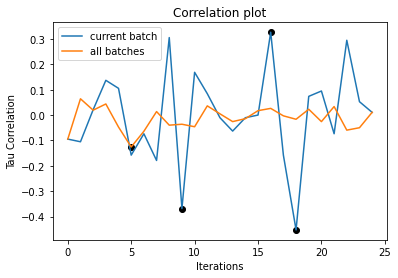

In [193]:
plot_correlation(batch_corr_list_7_pa, accumulate_corr_list_7_pa)

In [194]:
lists = [ co_oc, phon_conn, free_assoc, feat_norms]
# correlation  ,   p-value
batch_corr_list_4_pa, accumulate_corr_list_4_pa = network_dev(vocab, lists, preferential_attachment, 11, 20)

Vocab:  511
initial network size: 11
--WHILE 11 511

adding 20 nodes
 
-- Top 20 nodes [('deer', 28.0), ('lamb', 27.0), ('pig', 27.0), ('duck', 23.0), ('goose', 23.0), ('bread', 22.0), ('cheese', 22.0), ('raisin', 22.0), ('tractor', 22.0), ('turtle', 22.0), ('bus', 20.0), ('stone', 20.0), ('tuna', 20.0), ('potato', 19.0), ('alligator', 18.0), ('bear', 18.0), ('box', 18.0), ('frog', 18.0), ('horse', 18.0), ('rooster', 18.0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.042105263157894736, pvalue=0.8226828854421667)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=-0.042105263157894736, pvalue=0.8226828854421667)
 
current network size: 31
--WHILE 31 511

adding 20 nodes
 
-- Top 20 nodes [('cow', 405.0), ('moose', 390.0), ('strawberry', 373.0), ('zebra', 363.0), ('couch', 358.0), ('pickle', 348.0), ('squirrel', 344.0), ('sheep', 316.0), ('tiger', 314.0), ('pony', 303.0), ('penguin', 301.0), ('cake', 289.0), ('bathtub',

 
-- Top 20 nodes [('hurt', 745.0), ('draw', 743.0), ('finger', 742.0), ('fall', 740.0), ('coffee', 739.0), ('new', 733.0), ('cry', 729.0), ('under', 727.0), ('inside', 713.0), ('wet', 711.0), ('party', 696.0), ('sing', 692.0), ('open', 680.0), ('after', 674.0), ('catch', 673.0), ('pick', 673.0), ('eye', 666.0), ('bath', 665.0), ('cute', 665.0), ('pull', 664.0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.2947368421052632, pvalue=0.07402572925713644)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=-0.03712503712503712, pvalue=0.3724312392885085)
 
current network size: 271
--WHILE 271 511

adding 20 nodes
 
-- Top 20 nodes [('morning', 718.0), ('wash', 713.0), ('glass', 695.0), ('window', 692.0), ('person', 684.0), ('dance', 683.0), ('run', 683.0), ('hot', 676.0), ('flower', 656.0), ('old', 642.0), ('blow', 641.0), ('dinner', 629.0), ('farm', 624.0), ('fast', 624.0), ('drive', 619.0), ('hide', 619.0), ('last', 608.0

 
-- Top 20 nodes [('chalk', 97.0), ('grandpa', 97.0), ('downtown', 91.0), ('quiet', 91.0), ('mailman', 89.0), ('grandma', 86.0), ('nurse', 85.0), ('dryer', 84.0), ('sidewalk', 70.0), ('skate', 70.0), ('camping', 67.0), ('playground', 66.0), ('noisy', 64.0), ('purse', 62.0), ('underpants', 61.0), ('ankle', 52.0), ('toothbrush', 45.0), ('uncle', 43.0), ('flag', 19.0), ('aunt', 0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.1368421052631579, pvalue=0.4222502818286719)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=-0.0009298597194388775, pvalue=0.9752060292476957)
 
current network size: 511


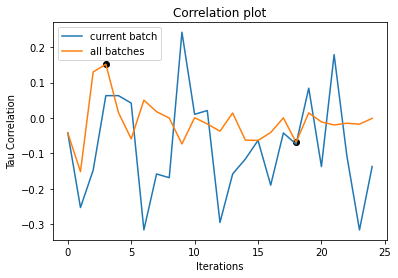

In [195]:
plot_correlation(batch_corr_list_4_pa, accumulate_corr_list_4_pa)

In [196]:
lists = [word_emb_layer, visual_layer, lancaster_layer]
# correlation  ,   p-value
batch_corr_list_3_pa, accumulate_corr_list_3_pa = network_dev(vocab, lists, preferential_attachment, 11, 20)

Vocab:  511
initial network size: 11
--WHILE 11 511

adding 20 nodes
 
-- Top 20 nodes [('tonight', 23.0), ('cowboy', 22.0), ('buy', 20.0), ('careful', 20.0), ('fine', 20.0), ('finish', 20.0), ('have', 20.0), ('high', 20.0), ('him', 20.0), ('inside', 20.0), ('more', 20.0), ('today', 20.0), ('will', 20.0), ('all', 19.0), ('be', 19.0), ('break', 19.0), ('day', 19.0), ('help', 19.0), ('here', 19.0), ('how', 19.0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0.28421052631578947, pvalue=0.08550171523715203)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=0.28421052631578947, pvalue=0.08550171523715203)
 
current network size: 31
--WHILE 31 511

adding 20 nodes
 
-- Top 20 nodes [('under', 614.0), ('better', 605.0), ('close', 604.0), ('friend', 604.0), ('mine', 604.0), ('away', 599.0), ('first', 599.0), ('go', 599.0), ('around', 590.0), ('present', 589.0), ('over', 574.0), ('out', 567.0), ('school', 567.0), ('off', 566.0), (

 
-- Top 20 nodes [('necklace', 632.0), ('flower', 560.0), ('towel', 559.0), ('trash', 559.0), ('button', 554.0), ('dress', 551.0), ('purse', 531.0), ('couch', 522.0), ('tricycle', 522.0), ('because', 521.0), ('tomorrow', 501.0), ('sleep', 483.0), ('potty', 463.0), ('water', 451.0), ('glass', 441.0), ('time', 441.0), ('closet', 436.0), ('zipper', 434.0), ('heavy', 431.0), ('what', 417.0)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.2736842105263158, pvalue=0.0983302187347563)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=0.07413127413127411, pvalue=0.07491197751352423)
 
current network size: 271
--WHILE 271 511

adding 20 nodes
 
-- Top 20 nodes [('light', 500.0), ('sofa', 482.0), ('shovel', 464.0), ('eye', 458.0), ('yellow', 449.0), ('bed', 433.0), ('glasses', 408.0), ('clock', 403.0), ('skate', 403.0), ('soft', 400.0), ('think', 390.0), ('asleep', 386.0), ('black', 385.0), ('ball', 384.0), ('chair', 384.0), ('p

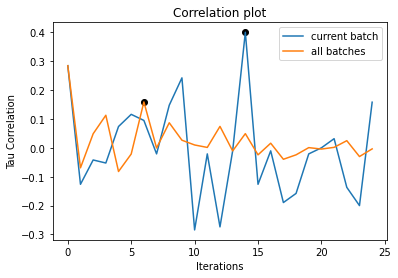

In [197]:
plot_correlation(batch_corr_list_3_pa, accumulate_corr_list_3_pa)

## Cosine Distance attachment

In [198]:
word_vectors = pickle.load( open( "word_layer_vectors.pickle", "rb" ))
visual_vectors = pickle.load( open( "visual_layer_vectors.pickle", "rb" ))
lancaster_vectors = pickle.load( open( "lancaster_layer_vectors.pickle", "rb" ))
len(word_vectors), len(visual_vectors), len(lancaster_vectors)

(529, 496, 524)

In [199]:
word_list = [tens for tens in word_vectors]
visual_list = [l for l in visual_vectors]
lancaster_list = [x for x in lancaster_vectors]

vec_vocab = list(set(word_list) & set(visual_list) & set(lancaster_list))
vec_vocab = [x for x in vec_vocab if x in aoa_vocab]
len(vec_vocab)

466

In [200]:
vector_lists = [word_emb_layer, visual_layer, lancaster_layer, co_oc, phon_conn, free_assoc, feat_norms]

In [201]:
cosine_graph = construct_graph_from_vocab(vec_vocab, [word_emb_layer, visual_layer, lancaster_layer])

In [202]:
def cosine_sim(G, list_connections):
    
    word_sim_list = []
    visual_sim_list = []
    lancaster_sim_list = []
    
    # this iterates through one nodes connections
    for conn in list_connections:
        # get sim score for word embedding
        word_score = torch.cosine_similarity(word_vectors[conn[0]].unsqueeze(0), word_vectors[conn[1]].unsqueeze(0))
        word_sim_list.append(word_score.numpy()[0])
        
        # get sim score for visual embedding
        x_visual = np.array(visual_vectors[conn[0]])
        y_visual = np.array(visual_vectors[conn[1]])    
        x_visual.reshape(1,-1)
        y_visual.reshape(1,-1)
        visual_score = cosine_similarity(x_visual.reshape(1,-1),y_visual.reshape(1,-1))
        visual_sim_list.append(visual_score)
        
        # get sim score for lancaster embedding
        x_lancaster = lancaster_vectors[conn[0]]
        y_lancaster = lancaster_vectors[conn[1]]
        lancaster_score = dot(x_lancaster, y_lancaster)/(norm(x_lancaster)*(norm(y_lancaster)))
        lancaster_sim_list.append(lancaster_score)

    
    # return the averages of the score lists
    word_avg = np.mean([avg for avg in word_sim_list])
    visual_avg = np.mean([avg for avg in visual_sim_list])
    lancaster_avg = np.mean([avg for avg in lancaster_sim_list]) 
    avg = (word_avg + visual_avg + lancaster_avg)/3
    
    # return the three averages
    return avg
        

In [203]:
def cosine_attachment(G, newly_added):
    '''
     cosine attachment function call takes in a graph 
     and a list of tuples --> for each node in the batch list,
     get all of its edges and create a list of tuples.
    '''
    
    # create a list of tuples (node, edge) for each edge a node has
    list_conns = get_node_connections(G, newly_added)
    
    node_avgs_list = []
    for arr in list_conns:
     
        # compute cosine similarity on batch nodes
        preds = cosine_sim(G, arr) # returns an average for word, visual and lancaster for one node

        # get the average of all the attachments for each node
        node_avgs_list.append(preds)
       
    
    # list with averages preferential attachment scores for each node in batch
    zip_lists = list(zip(newly_added, node_avgs_list))


    return zip_lists

In [205]:
lists = [ word_emb_layer, visual_layer, lancaster_layer]
# correlation  ,   p-value
batch_corr_list_3_cos, accumulate_corr_list_3_cos = network_dev(vec_vocab, lists, cosine_attachment, 6, 20)

Vocab:  466
initial network size: 6
--WHILE 6 466

adding 20 nodes


/Users/florianaciaglia/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/florianaciaglia/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AssertionError: 

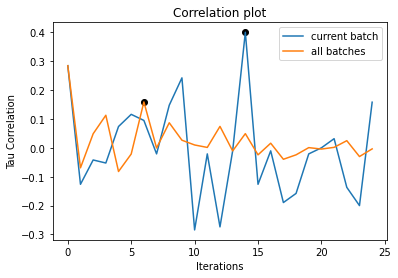

In [206]:
plot_correlation(batch_corr_list_3_pa, accumulate_corr_list_3_pa)

## Preferential acquisition

For preferential acquisition, the utility of a candidate node is its degree in the entire network. In our example, candidate node 1 has two connections in total, whereas candidate node 2 has five connections. So we have node1 = 2 and node2 = 5. Thus, according to pa, node 2 is more likely to enter the lexicon next. This figure is based on an example from Hills et al. (2009).

In [207]:
def preferential_acquisition(G, newly_added):
    '''
     preferntial acquisition function call takes in a graph 
     and a list of tuples --> for each node in the batch list,
     get all of its edges and create a list of tuples.
    '''
    
    # create a list of tuples (node, edge) for each edge a node has
    list_conns = get_node_connections(G, newly_added)
    
    node_avgs_list = []
    for arr in list_conns: # arr is a list of connections. 
#         print(arr)
        num_conns = len(arr) # get the length of arr to find how many connections a node has

        # get the average of all the attachments for each node
        node_avgs_list.append(num_conns)
   
        
    # list with averages preferential attachment scores for each node in batch
    zip_lists = list(zip(newly_added, node_avgs_list))

    return zip_lists

In [208]:
lists = [co_oc, phon_conn, free_assoc, feat_norms, word_emb_layer, visual_layer, lancaster_layer]
# correlation  ,   p-value
batch_corr_list_7_pac, accumulate_corr_list_7_pac = network_dev(vocab, lists, preferential_acquisition, 11, 20)

Vocab:  511
initial network size: 11
--WHILE 11 511

adding 20 nodes
 
-- Top 20 nodes [('bear', 7), ('get', 7), ('mommy', 7), ('a', 6), ('all', 6), ('buy', 6), ('careful', 6), ('close', 6), ('cowboy', 6), ('fix', 6), ('friend', 6), ('go', 6), ('have', 6), ('help', 6), ('high', 6), ('him', 6), ('lady', 6), ('mine', 6), ('more', 6), ('please', 6)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.2736842105263158, pvalue=0.0983302187347563)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=-0.2736842105263158, pvalue=0.0983302187347563)
 
current network size: 31
--WHILE 31 511

adding 20 nodes
 
-- Top 20 nodes [('where', 25), ('how', 24), ('she', 24), ('today', 24), ('bad', 23), ('break', 23), ('fine', 23), ('first', 23), ('good', 23), ('grandpa', 23), ('her', 23), ('school', 23), ('slow', 23), ('tonight', 23), ('around', 22), ('daddy', 22), ('finish', 22), ('old', 22), ('out', 22), ('play', 22)]
## Attachment at building 

 
-- Top 20 nodes [('cheese', 33), ('strawberry', 33), ('bowl', 32), ('napkin', 32), ('cup', 31), ('hose', 31), ('boots', 29), ('giraffe', 29), ('pumpkin', 29), ('pencil', 28), ('bread', 27), ('dish', 27), ('person', 27), ('apple', 26), ('basement', 26), ('necklace', 26), ('tissue', 26), ('wet', 26), ('bathroom', 25), ('eat', 25)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0.0736842105263158, pvalue=0.6771082386478994)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=0.030721966205837177, pvalue=0.4434838245514785)
 
current network size: 291
--WHILE 291 511

adding 20 nodes
 
-- Top 20 nodes [('scarf', 34), ('coat', 32), ('fork', 31), ('potty', 31), ('pickle', 30), ('food', 28), ('towel', 28), ('scissors', 27), ('basket', 26), ('cold', 26), ('bite', 25), ('bottle', 25), ('cake', 25), ('crayon', 25), ('hair', 25), ('owl', 25), ('potato', 25), ('mad', 24), ('paper', 24), ('park', 24)]
## Attachment at building time on c

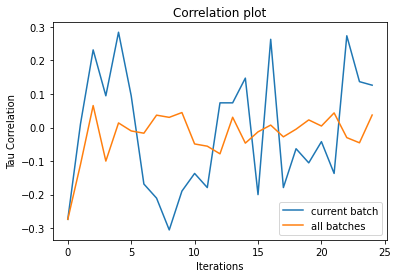

In [209]:
plot_correlation(batch_corr_list_7_pac, accumulate_corr_list_7_pac)

In [210]:
lists = [co_oc, phon_conn, free_assoc, feat_norms]
# correlation  ,   p-value
batch_corr_list_4_pac, accumulate_corr_list_4_pac = network_dev(vocab, lists, preferential_acquisition, 11, 20)

Vocab:  511
initial network size: 11
--WHILE 11 511

adding 20 nodes
 
-- Top 20 nodes [('a', 8), ('you', 8), ('box', 6), ('door', 6), ('house', 6), ('ball', 5), ('car', 5), ('chair', 5), ('dog', 5), ('pen', 5), ('pencil', 5), ('what', 5), ('all', 4), ('baby', 4), ('balloon', 4), ('bench', 4), ('brush', 4), ('bucket', 4), ('cat', 4), ('cow', 4)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0.0, pvalue=1.0)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=0.0, pvalue=1.0)
 
current network size: 31
--WHILE 31 511

adding 20 nodes
 
-- Top 20 nodes [('sled', 16), ('comb', 15), ('go', 15), ('there', 15), ('airplane', 14), ('bat', 14), ('boat', 14), ('hammer', 14), ('horse', 14), ('bear', 13), ('broom', 13), ('no', 13), ('pants', 13), ('stick', 13), ('train', 13), ('tricycle', 13), ('basket', 12), ('dish', 12), ('garage', 12), ('get', 12)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0.042105

 
-- Top 20 nodes [('dirty', 11), ('ice', 11), ('morning', 11), ('open', 11), ('paint', 11), ('sing', 11), ('tear', 11), ('touch', 11), ('dark', 10), ('drive', 10), ('drop', 10), ('ear', 10), ('lunch', 10), ('pick', 10), ('picture', 10), ('shake', 10), ('sick', 10), ('snow', 10), ('soup', 10), ('store', 10)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0.06315789473684211, pvalue=0.7246362205272814)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=-0.03835005574136009, pvalue=0.321889331141023)
 
current network size: 311
--WHILE 311 511

adding 20 nodes
 
-- Top 20 nodes [('wake', 12), ('window', 11), ('breakfast', 10), ('flower', 10), ('park', 10), ('sandwich', 10), ('slow', 10), ('sun', 10), ('after', 9), ('before', 9), ('build', 9), ('bye', 9), ('cover', 9), ('cracker', 9), ('farm', 9), ('fine', 9), ('fix', 9), ('hen', 9), ('high', 9), ('inside', 9)]
## Attachment at building time on current batch:
KendalltauResult(c

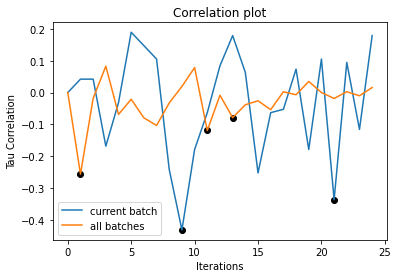

In [211]:
plot_correlation(batch_corr_list_4_pac, accumulate_corr_list_4_pac)

In [212]:
lists = [word_emb_layer, visual_layer, lancaster_layer]
# correlation  ,   p-value
batch_corr_list_3_pac, accumulate_corr_list_3_pac = network_dev(vocab, lists, preferential_acquisition, 11, 20)

Vocab:  511
initial network size: 11
--WHILE 11 511

adding 20 nodes
 
-- Top 20 nodes [('all', 7), ('finish', 7), ('mine', 7), ('slow', 7), ('around', 6), ('bear', 6), ('block', 6), ('buy', 6), ('careful', 6), ('cowboy', 6), ('day', 6), ('fine', 6), ('fix', 6), ('friend', 6), ('her', 6), ('here', 6), ('high', 6), ('mommy', 6), ('need', 6), ('out', 6)]
## Attachment at building time on current batch:
KendalltauResult(correlation=-0.12631578947368421, pvalue=0.4605237944389165)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=-0.12631578947368421, pvalue=0.4605237944389165)
 
current network size: 31
--WHILE 31 511

adding 20 nodes
 
-- Top 20 nodes [('under', 26), ('have', 25), ('more', 25), ('school', 25), ('tonight', 25), ('him', 24), ('inside', 24), ('today', 24), ('where', 24), ('be', 23), ('break', 23), ('get', 23), ('lady', 23), ('mailman', 23), ('over', 23), ('bring', 22), ('first', 22), ('go', 22), ('bedroom', 21), ('behind', 21)]
## Attachment 

 
-- Top 20 nodes [('ball', 11), ('blue', 11), ('heavy', 11), ('time', 11), ('bowl', 10), ('glasses', 10), ('soft', 10), ('yellow', 10), ('black', 9), ('broom', 9), ('chair', 9), ('clock', 9), ('closet', 9), ('cold', 9), ('hot', 9), ('plant', 9), ('think', 9), ('tricycle', 9), ('yesterday', 9), ('asleep', 8)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0.1368421052631579, pvalue=0.4222502818286719)
 
## Attachment at building time on growing network:
KendalltauResult(correlation=0.005581157194060421, pvalue=0.8892799078071668)
 
current network size: 291
--WHILE 291 511

adding 20 nodes
 
-- Top 20 nodes [('door', 10), ('tomorrow', 10), ('hard', 8), ('nap', 8), ('pen', 8), ('potty', 8), ('say', 8), ('see', 8), ('skate', 8), ('above', 7), ('butterfly', 7), ('full', 7), ('lamp', 7), ('paint', 7), ('pour', 7), ('tickle', 7), ('water', 7), ('when', 7), ('wipe', 7), ('sled', 7)]
## Attachment at building time on current batch:
KendalltauResult(correlation=0

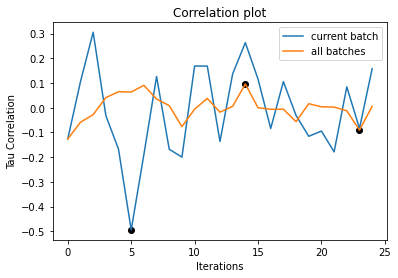

In [213]:
plot_correlation(batch_corr_list_3_pac, accumulate_corr_list_3_pac)